# Build a Multimodal Shopping Agent with Voyage AI and Pixeltable

What happens when a customer searches for "birthday gift for a 6-year-old who loves math and dinosaurs"? Traditional keyword search can fail, because no product listing contains those exact words. Semantic search understands *meaning*, not just keywords, but meaning alone isn't always enough. Sometimes the customer cares about what a product looks like, not what the description says. And even good search results can be sharpened by reranking them against the original question.

In this tutorial, you'll build a shopping assistant that handles all three: text intent, visual style, and reranked precision. We'll start simple and layer on capabilities, so you can see each piece do its job before we combine them.

```
┌────────────────────────────────────────────────────────────────────────────────┐
│  DATA              EMBED             SEARCH            AGENT         RERANK    │
│                                                                                │
│  ┌────────┐      ┌──────────┐      ┌──────────┐     ┌──────────┐  ┌────────┐   │
│  │Products│─────▶│ Voyage   │─────▶│Similarity│────▶│ LLM Tool │─▶│Rerank  │   │
│  │  Table │      │Embeddings│      │  Search  │     │ Calling  │  │  2.5   │   │
│  └────────┘      └──────────┘      └──────────┘     └──────────┘  └────────┘   │
│      │                │                  │                │             │      │
│  Amazon           Text +            Query by          Agent picks   Reorder    │
│  product data     image vectors     text              the right     results    │
│                                                       search tool   by fit     │
│                                                                                │
└────────────────────────────────────────────────────────────────────────────────┘
```

## In this notebook

1. **Load product data:** Import Amazon listings into a Pixeltable table with images, descriptions, and metadata
2. **Add embedding indexes:** Build text and multimodal indexes using Voyage AI models
3. **Search for similar items:** Run text similarity and cross-modal (text-to-image) search
4. **Build reusable query functions:** Turn ad-hoc queries into persistent, orchestrated workflows
5. **Build a multimodal agent:** Wire both search tools into an LLM that picks the right one per question
6. **Improve results with reranking:** Use Voyage AI's reranker to sharpen answer quality

| Component | Technology | Role in this notebook |
|-----------|------------|------------------------|
| **Embeddings** | Voyage AI `voyage-3.5` | Semantic text retrieval |
| **Reranker** | Voyage AI `rerank-2.5` | Reorders candidates for precision |
| **Multimodal Search** | Voyage AI `voyage-multimodal-3.5` | Text-to-image retrieval |
| **AI Data Infrastructure** | Pixeltable | Stores data, manages indexes, orchestrates pipelines |

## About Pixeltable

Pixeltable is AI data infrastructure where the table is the unit of work. A few things worth knowing going in:

- **Incremental by default.** Add new data, and only the new rows get processed. Embeddings, transformations, and model calls don't re-run on data that's already been handled.
- **Embedding indexes and similarity search are first-class table operations.** You don't bolt on a separate vector database; retrieval lives alongside your data.
- **Images, video, audio, and documents live in table columns** right next to structured data like strings, numbers, and JSON.
- **Inputs, intermediates, and outputs all stay queryable.** Nothing disappears into a pipeline. Every step is inspectable as table data.


## Setup

Install the required packages, set up API keys, and configure the environment.


In [ ]:
%pip install -qU pixeltable voyageai openai

In [1]:
import getpass
import os

if "VOYAGE_API_KEY" not in os.environ:
    os.environ["VOYAGE_API_KEY"] = getpass.getpass("Enter your Voyage AI API key: ")

In [2]:
import pixeltable as pxt
import pixeltable.functions as pxtf

Pixeltable uses directories to organize tables. We'll start with a fresh directory for this tutorial.

In [ ]:
pxt.drop_dir("ecommerce_search", force=True)
pxt.create_dir("ecommerce_search")

You can view all of your directories:

In [ ]:
pxt.list_dirs()

## Load Amazon Product Data

We'll use a pre-processed subset of the [Amazon Product Dataset 2020](https://huggingface.co/datasets/calmgoose/amazon-product-data-2020), which contains real product listings with rich metadata including:

- Product names and descriptions
- Categories and specifications
- Pricing information
- One image URL per row

The dataset contains ~1,800 rows from 500 products, with each product having 1-7 images.

The dataset URL uses GitHub raw content for reproducibility:

In [4]:
DATASET_URL = "https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/amazon_products_with_images.parquet"

We read the parquet file into a Pandas dataframe and pass it as the source for a new Pixeltable table. `on_error='ignore'` tells Pixeltable to skip rows where Amazon image URLs have expired rather than failing the entire load.

In [5]:
import pandas as pd

df = pd.read_parquet(DATASET_URL)

products = pxt.create_table(
    "ecommerce_search.products",
    source=df,
    schema_overrides={
        "Uniq_Id": pxt.String,
        "Product_Name": pxt.String,
        "Category": pxt.String,
        "Selling_Price": pxt.String,
        "About_Product": pxt.String,
        "Image": pxt.Image,
    },
    on_error="ignore",
)

Created table 'products'.
Inserted 1779 rows with 10 errors across 2 columns (products.None, products.Image) in 11.99 s (148.40 rows/s)


In a typical setup, you'd load this data into Pandas, push it to a database, then separately send images to object storage. Here, one `create_table` call handles structured data and images together. The 10 errors in the output are rows where Amazon image URLs have expired. Pixeltable logged them and kept going.

Pixeltable can work with files from anywhere: local paths, URLs, or cloud storage. It stores file references and only downloads to disk on access. Learn more about [working with remote files](https://docs.pixeltable.com/howto/cookbooks/data/data-import-s3), [tables and data operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations), and the [type system](https://docs.pixeltable.com/platform/type-system). 

We can see the table created in our directory:

In [6]:
pxt.list_tables("ecommerce_search")

['ecommerce_search/products']

You can clean and filter data directly in the table before applying models like embeddings. Here, we need to remove rows where `About_Product` is none or empty because these won't produce useful embeddings. 

In [ ]:
products.delete(where=(products.About_Product is None) | (products.About_Product == ""))

37 rows deleted.

Several rows were deleted. Let's count the remaining rows we can work with:

In [8]:
products.count()

1742

Pixeltable queries work like you'd expect from SQL:

- `select()` picks columns, refined with `order_by()` and `where()`
- `collect()` executes the query and returns results
- `limit(n)`, `head(n)`, and `tail(n)` control how many rows come back

Let's see what products we're working with:

Product_Name,Image,Selling_Price,About_Product
Tamiya 35157 1/35 U.S. Marine M60A1 Tank Plastic Model Kit,,\$36.20,Make sure this fits by entering your model number. | Highly accurate static display model.
Redcat Racing BS903-089 2 X 10 Pin (12Piece),,\$6.98,"Genuine Redcat Racing Replacement part # BS903-089 | Use only genuine Redcat Racing Replacement parts to achieve the best performance with your Redcat Racing vehicles. | Please consult your user's manual to ensure this is the correct part for your model. | For troubleshooting and Warranty information please contact a Redcat Racing customer service specialist at 602-454-6445 or by emailing amazonsupport@redcatracing.Com | Compatible with the following Redcat Racing vehicles: caldera 10E, caldera 3.0, caldera SC 10E, caldera XB 10E, Earthquake 3.5, Earthquake 8E, fossa SC10, ground Pounder, piranha-tr10, Shredder"
"Blaze and the Monster Machines Value Pack Foil Swirl Decorations, Party Favor",,\$7.08,"Make sure this fits by entering your model number. | 12 swirl decorations | 6 swirls, 3 swirls w/ paper cutouts: 7"" and 3 swirls w/ paper cutouts: 5"" | Fill the room with these vibrant swirls for a fun-filled celebration | Hanging decorations for parties and fun occasions"

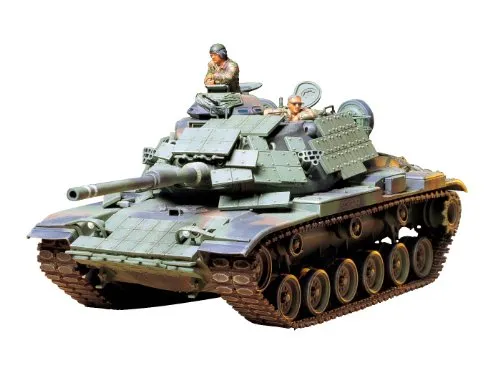
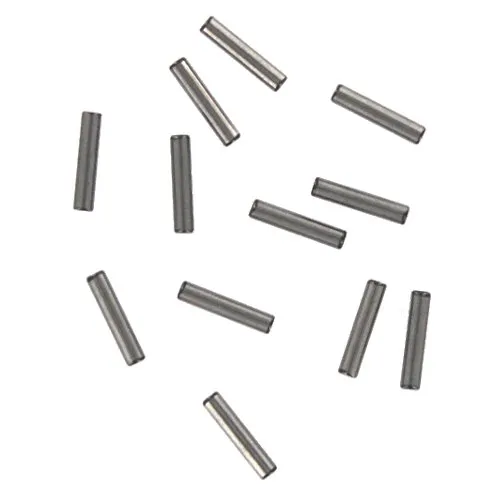
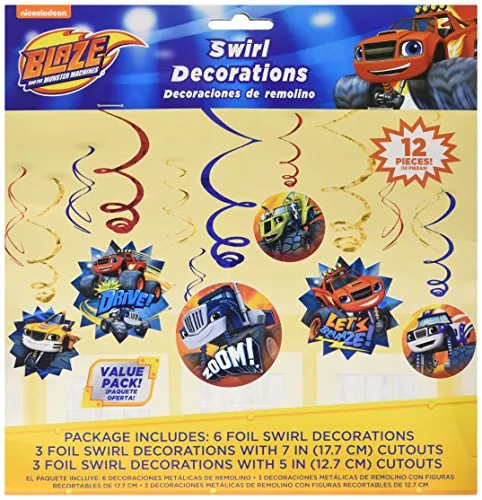

In [9]:
products.select(
    products.Product_Name,
    products.Image,
    products.Selling_Price,
    products.About_Product,
).tail(3)

We can also filter rows with a keyword match using `where()` and `contains()`:

Product_Name,Image,Selling_Price,About_Product
"Terra by Battat – 4 Dinosaur Toys, Medium – Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)",,\$18.66,"Make sure this fits by entering your model number. | 4 medium-sized dinosaurs for kids, with lifelike pose, accurate ratio, and exquisitely detailed paint | Includes: Parasaurolophus walkeri, Stegosaurus ungulatus, Pachyrhinosaurus, and euoplocephalus tutus toy dinos | Museum Quality: classic toy dinosaurs designed by an internationally renowned paleo-artist | Educational toy: dinosaur toys for kids spark curiosity about paleontology, science, and natural History | Dimensions: Dimensions: miniature figurines measure 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately toys 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately | No batteries required, just imagination! | Earth-friendly recyclable packaging | Age: suggested for ages 3+ | Collect them all! Discover the entire Terra by Battat family of animal toy figurines and dinosaur playsets!"
"Terra by Battat – 4 Dinosaur Toys, Medium – Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)",,\$18.66,"Make sure this fits by entering your model number. | 4 medium-sized dinosaurs for kids, with lifelike pose, accurate ratio, and exquisitely detailed paint | Includes: Parasaurolophus walkeri, Stegosaurus ungulatus, Pachyrhinosaurus, and euoplocephalus tutus toy dinos | Museum Quality: classic toy dinosaurs designed by an internationally renowned paleo-artist | Educational toy: dinosaur toys for kids spark curiosity about paleontology, science, and natural History | Dimensions: Dimensions: miniature figurines measure 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately toys 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately | No batteries required, just imagination! | Earth-friendly recyclable packaging | Age: suggested for ages 3+ | Collect them all! Discover the entire Terra by Battat family of animal toy figurines and dinosaur playsets!"
"Terra by Battat – 4 Dinosaur Toys, Medium – Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)",,\$18.66,"Make sure this fits by entering your model number. | 4 medium-sized dinosaurs for kids, with lifelike pose, accurate ratio, and exquisitely detailed paint | Includes: Parasaurolophus walkeri, Stegosaurus ungulatus, Pachyrhinosaurus, and euoplocephalus tutus toy dinos | Museum Quality: classic toy dinosaurs designed by an internationally renowned paleo-artist | Educational toy: dinosaur toys for kids spark curiosity about paleontology, science, and natural History | Dimensions: Dimensions: miniature figurines measure 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately toys 6.25-8.5 (L) 1.5-2.25 (W) 2.25-3.5 (H) inches approximately | No batteries required, just imagination! | Earth-friendly recyclable packaging | Age: suggested for ages 3+ | Collect them all! Discover the entire Terra by Battat family of animal toy figurines and dinosaur playsets!"

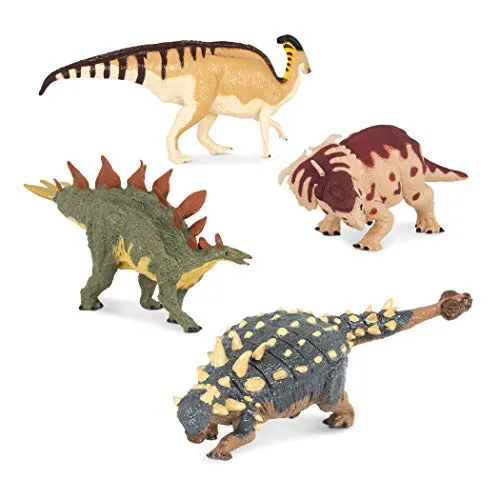
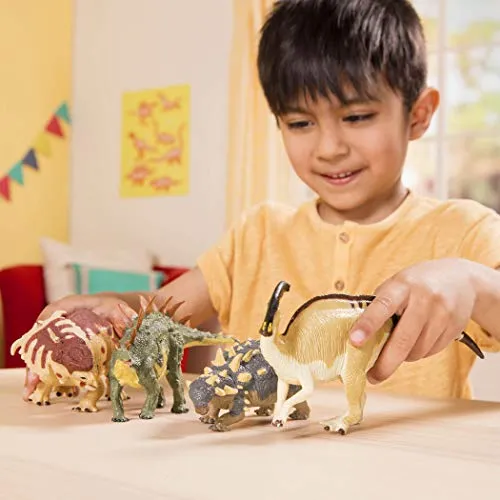
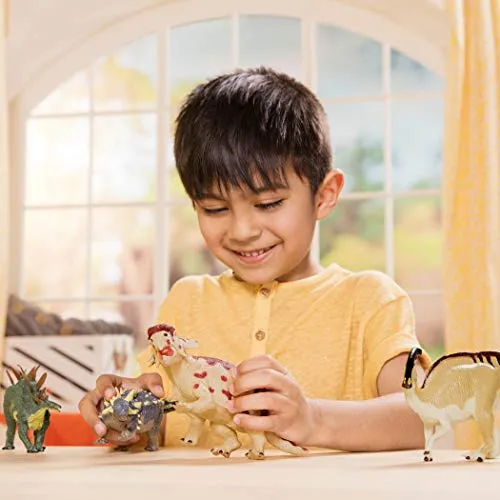

In [10]:
products.where(products.About_Product.contains("dino")).select(
    products.Product_Name,
    products.Image,
    products.Selling_Price,
    products.About_Product,
).limit(3).collect()

There are definitely some dinosaurs in this product catalog. And there are duplicate items, which is par for the course with Amazon since there can be multiple listings for identical items in their marketplace.

## Add Text & Multimodal Embeddings for Search

In Pixeltable, an embedding index can be attached to any column. We'll add two to the same table using separate Voyage AI models. Why two?

- **Each captures a different signal.** Text embeddings encode what the listing *says*; image embeddings encode what the product *looks like*.
- **You can query each one independently.** Search descriptions for "dinosaur figurine" or search images for "cuddly plush toy." Different retrieval paths for different questions.
- **You can add more indexes later** without touching the existing ones, so you can compare models or methods side by side.

First, text embeddings on the `About_Product` column:

In [11]:
products.add_embedding_index(
    idx_name="txt_idx",
    column=products.About_Product,
    embedding=pxtf.voyageai.embeddings.using(model="voyage-3.5", input_type="document"),
    if_exists="replace",
)

Now add an image embedding index on the same table. These take a bit longer to generate because Voyage AI processes the full image for each row.

In [12]:
products.add_embedding_index(
    idx_name="img_idx",
    column=products.Image,
    embedding=pxtf.voyageai.multimodal_embed.using(
        model="voyage-multimodal-3.5", input_type="document"
    ),
    if_exists="replace",
)

We can see both of our new indexes now in our table schema:

In [13]:
products

table 'ecommerce_search/products'

    Column Name    Type Computed With
        Uniq_Id  String              
   Product_Name  String              
       Category  String              
  Selling_Price  String              
  About_Product  String              
          Image   Image              
      image_idx     Int              

 Index Name         Column  Metric                                          Embedding
    txt_idx  About_Product  cosine  embeddings(About_Product, model='voyage-3.5', ...
    img_idx          Image  cosine  multimodal_embed(Image, model='voyage-multimod...

### What just happened

Pixeltable sent each product description and image to the Voyage AI APIs, stored the resulting vectors, and built two searchable indexes. 

What we didn't set up: a separate vector database, an ETL pipeline to sync product data with an embedding store, a cron job to keep them in agreement. The indexes live in the same table as the data.

Whenever you insert new products into this table later, everything updates incrementally:

1. The Voyage AI APIs compute embeddings for only the new products
2. The index adds the new vectors
3. We can search right away without re-indexing or re-processing any existing rows in our table

## Search for Similar Items

Now that we have indexes, we can search. Pixeltable provides a `.similarity()` method on any indexed column. You pass it a query, and it works like any other expression in `order_by`, `select`, and `where`.

We have two indexes, so we have two ways to search:

- **Text search** (`txt_idx`): pass a text query, find products whose *descriptions* are semantically similar
- **Image search** (`img_idx`): pass a text query, find products whose *photos* match visually

Let's try both.

We'll start with a text query on the product descriptions. For text queries, pass the `string=` argument.

In [14]:
query = "realistic, scientifically accurate dinosaur figurines"
txt_sim = products.About_Product.similarity(string=query, idx="txt_idx")

We'll set a similarity threshold to filter out weak matches. This is optional, but it keeps results focused. You can adjust or remove it depending on how broad you want your search to be.

In [15]:
SIM_THRESHOLD = 0.5

Now we compose a query from the similarity expression. These results aren't stored; they're for exploration.

In [16]:
txt_results = (
    products.order_by(txt_sim, asc=False)
    .select(
        products.Product_Name, products.Image, products.About_Product, score=txt_sim
    )
    .where(txt_sim > SIM_THRESHOLD)
)

Product_Name,Image,About_Product,score
"Schleich North America Tyrannosaurus Rex Toy Figure, Red",,Make sure this fits by entering your model number. | Get to know the famous T-Rex without the danger! | Realistically detailed for optimal play and educational purposes! | Bring it to life with its moveable lower jaw! | Individually crafted and skillfully painted | Composed of high quality plastic to ensure durability! | Hand painted | Historically accurate,0.864
"Schleich North America Tyrannosaurus Rex Toy Figure, Red",,Make sure this fits by entering your model number. | Get to know the famous T-Rex without the danger! | Realistically detailed for optimal play and educational purposes! | Bring it to life with its moveable lower jaw! | Individually crafted and skillfully painted | Composed of high quality plastic to ensure durability! | Hand painted | Historically accurate,0.864
"Schleich North America Tyrannosaurus Rex Toy Figure, Red",,Make sure this fits by entering your model number. | Get to know the famous T-Rex without the danger! | Realistically detailed for optimal play and educational purposes! | Bring it to life with its moveable lower jaw! | Individually crafted and skillfully painted | Composed of high quality plastic to ensure durability! | Hand painted | Historically accurate,0.864

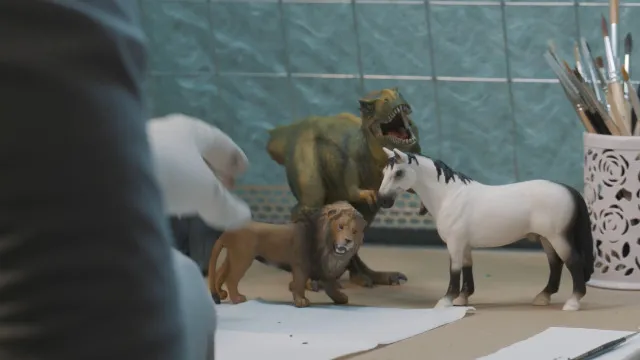
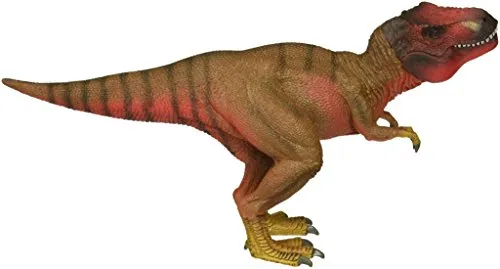
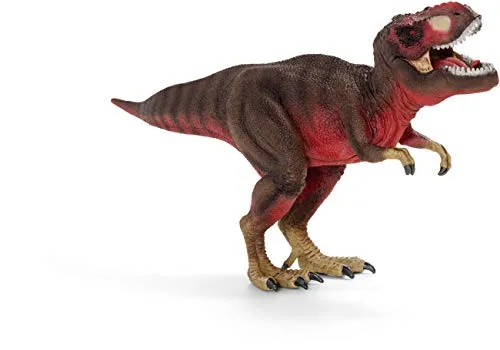

In [17]:
txt_results.limit(3).collect()

Now for the cross-modal search. This is where Voyage AI's `voyage-multimodal-3.5` model comes in: we pass a *text* query and search across *images*. The model maps both modalities into the same embedding space, so "plush, cuddly stuffed dinosaur" finds products that *look* cuddly, even if the listing never uses that word.

Product_Name,Image,score
"Wild Republic T-Rex Plush, Dinosaur Stuffed Animal, Plush Toy, Gifts for Kids, Dinosauria 17 Inches",,0.59
"Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green",,0.575
"Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green",,0.515

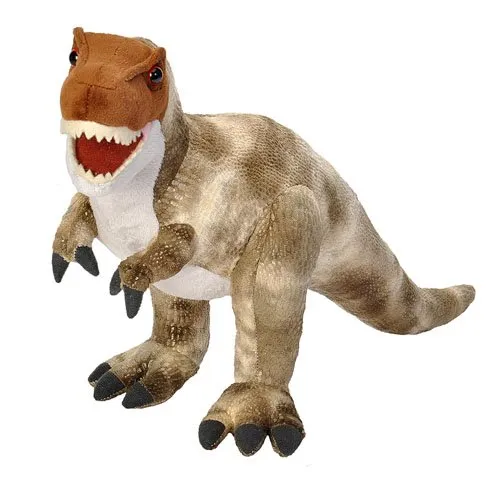
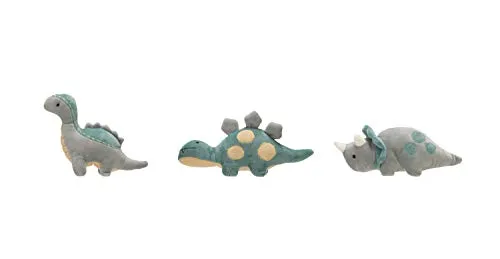
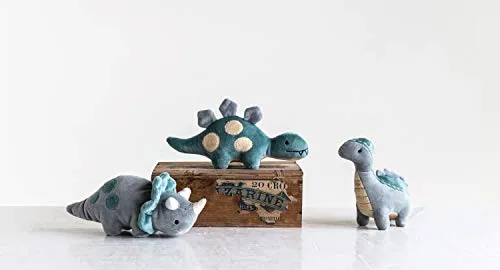

In [18]:
sim_i = products.Image.similarity(
    string="plush, cuddly stuffed dinosaur", idx="img_idx"
)

img_results = (
    products.order_by(sim_i, asc=False)
    .select(products.Product_Name, products.Image, score=sim_i)
    .where(sim_i > SIM_THRESHOLD)
)

img_results.limit(3).collect()

## Build Reusable Retrieval Queries

Ad-hoc queries work well for exploration, but we can also make search reusable and persistent. In this section, we'll define `@pxt.query` functions for text and image search, then wire them into a dedicated table so results are computed automatically on every insert. 

This gives us two things: a standalone workflow for testing and inspecting search results, and reusable query functions that we'll later hand to an agent as tools.

The pattern has three components:

1. **Query functions** (`@pxt.query`) that turn the search-and-rank pattern into reusable functions. We'll create one for `text_search` and another for `image_search`.

2. **A dedicated table** with a column for query strings. This gives us a persistent data structure to store queries as rows.

3. **Computed columns** that call the query functions. This is the orchestration layer: Pixeltable runs the search functions automatically whenever a new row is inserted.

We define two query functions: `text_search` (uses `txt_idx`) and `image_search` (uses `img_idx`). Each takes a query string and returns ranked results.

In [19]:
@pxt.query
def text_search(query_text: str, limit: int = 5):
    sim = products.About_Product.similarity(string=query_text, idx="txt_idx")
    return (
        products.where(sim > SIM_THRESHOLD)
        .order_by(sim, asc=False)
        .limit(limit)
        .select(
            products.Uniq_Id,
            products.Product_Name,
            products.Selling_Price,
            score=sim,
        )
    )


@pxt.query
def image_search(query_text: str, limit: int = 5):
    sim = products.Image.similarity(string=query_text, idx="img_idx")
    return (
        products.where(sim > SIM_THRESHOLD)
        .order_by(sim, asc=False)
        .limit(limit * 3)
        .select(
            products.Uniq_Id,
            products.Product_Name,
            products.Selling_Price,
            score=sim,
        )
    )

Next, we make a fresh table for this workflow to store our search queries for now, and our search results in the next step.

In [20]:
# Table to hold user queries
searches = pxt.create_table(
    "ecommerce_search.searches_live",
    {"query": pxt.String},
    if_exists="replace",
)

Created table 'searches_live'.


In [21]:
searches

table 'ecommerce_search/searches_live'

 Column Name    Type Computed With
       query  String

Now we add computed columns that call our query functions. This is the orchestration: Pixeltable runs them automatically on every insert.

In [22]:
# Computed columns execute the query functions
searches.add_computed_column(
    text_results=text_search(searches.query, limit=5),
    if_exists="replace",
)

searches.add_computed_column(
    image_results=image_search(searches.query, limit=5),
    if_exists="replace",
)

Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

The table is empty for now, but it's an orchestrated workflow waiting for data. As soon as we insert a query string, Pixeltable runs the search functions automatically.

In [23]:
searches.count()

0

Insert queries, and both search functions run automatically.

In [24]:
# Insert queries
searches.insert(
    [
        {"query": "realistic, scientifically accurate dinosaur figurines"},
        {"query": "colorful, cuddly plush dinosaurs"},
        {"query": "teach math skills with dinosaurs"},
    ]
)

Inserted 3 rows with 0 errors in 2.24 s (1.34 rows/s)


3 rows inserted.

In [26]:
searches.tail(1)

query  \
0  realistic, scientifically accurate dinosaur fi...   

                                        text_results  \
0  [{'score': 0.8640849814862197, 'Uniq_Id': '5b9...   

                                       image_results  
0  [{'score': 0.6380760844663435, 'Uniq_Id': 'f8c...

The output looks different from the similarity results earlier. That's a shape difference:

- **Before:** one row per product, scalar columns (name, image, score), clean table rendering.
- **Now:** one row per *query*, with search results stored as a JSON list inside a single column. We extract fields with `[0:5].Product_Name`, which gives arrays instead of individual rows.

Less pretty in a notebook, but more useful in practice: this JSON structure is machine-readable, which is exactly what an agent or application needs downstream.

In [29]:
# Collect text search output
searches.select(
    searches.query,
    text_matches=searches.text_results[0:3].Product_Name,
    prod_prices=searches.text_results[0:3].Selling_Price,
).collect()

query,text_matches,prod_prices
teach math skills with dinosaurs,"[""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+""]","[""\$17.49"", ""\$17.49"", ""\$17.49""]"
"colorful, cuddly plush dinosaurs","[""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers""]","[""\$11.99"", ""\$11.99"", ""\$11.99""]"
"realistic, scientifically accurate dinosaur figurines","[""Schleich North America Tyrannosaurus Rex Toy Figure, Red"", ""Schleich North America Tyrannosaurus Rex Toy Figure, Red"", ""Schleich North America Tyrannosaurus Rex Toy Figure, Red""]","[""\$21.24"", ""\$21.24"", ""\$21.24""]"


In [30]:
# Collect image search output
searches.select(
    searches.query,
    img_matches=searches.image_results[0:3].Product_Name,
    prod_prices=searches.image_results[0:3].Selling_Price,
).collect()

query,img_matches,prod_prices
teach math skills with dinosaurs,"[""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+""]","[""\$17.49"", ""\$17.49"", ""\$17.49""]"
"colorful, cuddly plush dinosaurs","[""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall""]","[""\$39.99"", ""\$39.99"", ""\$7.89""]"
"realistic, scientifically accurate dinosaur figurines","[""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)"", ""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)"", ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall""]","[""\$18.66"", ""\$18.66"", ""\$7.89""]"


At this point we have the building blocks: a product table with two embedding indexes, similarity search that works across text and images, and reusable query functions wired into an orchestrated workflow. Next, we'll hand these query functions to an LLM as tools and let it decide how to search.

## Build a Multimodal Agent

Some searches might be solved by reading the product text description. Others are about what a product looks like, not what the listing says. By giving the agent two tools (each powered by Voyage AI's embeddings), it can choose the right retrieval path based on the question. 

The flow:

1. The LLM receives a question and decides to call a search tool: either text or image.
2. Pixeltable executes the search and stores the results.
3. A second LLM call assembles a final answer from what the tool found.

Every step is a computed column, so the whole chain runs automatically when you insert a new question.

The agent uses OpenAI for the LLM calls. Voyage AI handles the retrieval; OpenAI handles the reasoning.

In [31]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

`pxt.tools()` takes our query functions and generates the tool schema that OpenAI's API expects. When we pass this to `chat_completions` in the next step, the LLM can decide to call `text_search` or `image_search`, and Pixeltable handles the execution and stores the results.

In [32]:
agent_tools = pxt.tools(text_search, image_search)

The agent table has one input column: the question. Everything else is computed.

In [33]:
mm_agent = pxt.create_table(
    "ecommerce_search.mm_agent", {"question": pxt.String}, if_exists="replace"
)

Created table 'mm_agent'.


The system prompt tells the agent what tools it has and when to use each one:

In [34]:
SYSTEM_PROMPT = """You are an expert personal shopping assistant. 
Your goal is to help users find and compare products with ease. 
Be conversational, warm, and proactive.

You have two tools:
1. text_search: Find products by semantic text search.
2. image_search: Find products by visual similarity from a text query.

Choose the best tool for the request. Use image search for appearance/style requests.

Guidelines:
- Be conversational and warm, not robotic
- Present 2-3 top-tier options rather than overwhelming lists
- Explain why each product fits what they described
- Keep responses concise
"""

In [35]:
mm_agent.add_computed_column(
    llm_response=pxtf.openai.chat_completions(
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": mm_agent.question},
        ],
        model="gpt-4o-mini",
        tools=agent_tools,
    ),
    if_exists="replace",
)

mm_agent.add_computed_column(
    tool_results=pxtf.openai.invoke_tools(agent_tools, mm_agent.llm_response),
    if_exists="replace",
)

Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

The agent's tool results will come back as structured data, but we need to assemble them into a prompt for a second LLM call that produces the final answer. This UDF collects the product names and prices from the tool output and formats them into a concise context block.

In [37]:
@pxt.udf
def assemble_answer_prompt(question: str, tool_results: dict) -> list[dict]:
    rows = []
    seen = set()
    for outputs in (tool_results or {}).values():
        if outputs is None:
            continue
        for output in outputs:
            if output is None:
                continue
            vals = output if isinstance(output, list) else [output]
            for row in vals:
                if not isinstance(row, dict):
                    continue
                pid = row.get("Uniq_Id", "")
                if pid in seen:
                    continue
                seen.add(pid)
                rows.append(
                    f"- {row.get('Product_Name', 'Unknown')} - {row.get('Selling_Price', 'N/A')}"
                )

    context = "\n".join(rows[:10]) if rows else "No results found."
    return [
        {
            "role": "system",
            "content": "You summarize product options clearly and briefly.",
        },
        {
            "role": "user",
            "content": f"Question: {question}\n\nProducts Found:\n{context}\n\nGive a concise recommendation.",
        },
    ]

Now we close the loop with two more computed columns: one that assembles the answer prompt from tool results, and one that sends that prompt to the LLM for a final answer. When a question is inserted, Pixeltable runs the entire chain automatically.

In [38]:
mm_agent.add_computed_column(
    answer_prompt=assemble_answer_prompt(mm_agent.question, mm_agent.tool_results),
    if_exists="replace",
)

mm_agent.add_computed_column(
    answer=pxtf.openai.chat_completions(
        messages=mm_agent.answer_prompt, model="gpt-4o-mini"
    )["choices"][0]["message"]["content"],
    if_exists="replace",
)

Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [39]:
mm_agent

table 'ecommerce_search/mm_agent'

    Column Name            Type                                      Computed With
       question          String                                                   
   llm_response  Required[Json]  chat_completions(messages=[{'role': 'system', ...
   tool_results  Required[Json]  {'text_search': map(_openai_response_to_pxt_to...
  answer_prompt            Json     assemble_answer_prompt(question, tool_results)
         answer            Json  chat_completions(messages=answer_prompt, model...

Look at the `Computed With` column in the schema above. The table *is* the workflow documentation. You can see the entire agent pipeline at a glance: LLM call, tool invocation, answer assembly, final response. If someone new joins the project, the schema tells them what happens and in what order.

The pipeline is ready. Let's give it some questions.

In [40]:
mm_agent.insert(
    [
        {"question": "Find me realistic, scientifically accurate dinosaur figurines"},
        {"question": "Show me colorful, cuddly plush dinosaurs"},
        {"question": "What is a good toy to teach math skills with dinosaurs?"},
    ]
)

Inserted 3 rows with 0 errors in 10.34 s (0.29 rows/s)


3 rows inserted.

One insert, and Pixeltable ran the full chain: an LLM call that chose to invoke the text search tool, the tool execution itself, answer prompt assembly, and a second LLM call to produce the final recommendation. Every intermediate result is stored in the table. We can inspect any step.

In [41]:
mm_agent.select(mm_agent.question, mm_agent.answer).collect()

question,answer
"Find me realistic, scientifically accurate dinosaur figurines","I recommend the Schleich North America Tyrannosaurus Rex Toy Figure for a realistic and scientifically accurate dinosaur figurine. Priced at \$21.24, it's known for its detailed design and durability."
What is a good toy to teach math skills with dinosaurs?,"A great toy for teaching math skills with dinosaurs is the Learning Resources Dino Math Tracks Game. It focuses on place value, counting, addition, and subtraction and is suitable for ages 6 and up, priced at \$17.49."
"Show me colorful, cuddly plush dinosaurs","For colorful and cuddly plush dinosaurs, I recommend the **Wild Republic T-Rex Plush** for \$14.40. It's a soft stuffed animal, perfect as a gift for kids. For a variety of options, consider the **Creative Co-op Green & Grey Plush Dinosaur Rattles,** which includes a set of three styles for \$39.99. Both options are adorable and great for fun and play!"


Try inserting your own questions. The pipeline is live: every new row triggers the full chain, from tool selection through search to the final answer.

In [42]:
# Check the tool's answer against text similarity search
searches.insert([{"query": "realistic, scientifically accurate dinosaur figurines"}])
searches.select(
    searches.query,
    text_names=searches.text_results[0:5].Product_Name,
    text_prices=searches.text_results[0:5].Selling_Price,
).tail(1)

Inserted 1 row with 0 errors in 0.86 s (1.17 rows/s)


query,text_names,text_prices
"realistic, scientifically accurate dinosaur figurines","[""Schleich North America Tyrannosaurus Rex Toy Figure, Red"", ""Schleich North America Tyrannosaurus Rex Toy Figure, Red"", ""Schleich North America Tyrannosaurus Rex Toy Figure, Red"", ""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)"", ""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)""]","[""\$21.24"", ""\$21.24"", ""\$21.24"", ""\$18.66"", ""\$18.66""]"


In [43]:
# Check the tool's answer against image similarity search
searches.insert([{"query": "colorful, cuddly plush dinosaurs"}])
searches.select(
    searches.query,
    image_names=searches.image_results[0:5].Product_Name,
    image_prices=searches.image_results[0:5].Selling_Price,
).tail(1)

Inserted 1 row with 0 errors in 0.87 s (1.14 rows/s)


query,image_names,image_prices
"colorful, cuddly plush dinosaurs","[""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall"", ""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)"", ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall""]","[""\$39.99"", ""\$39.99"", ""\$7.89"", ""\$18.66"", ""\$7.89""]"


## Improve Results with Reranking

Embedding search is fast and broad. It casts a wide net. But the top results aren't always the best fit for the specific question. Voyage AI's **rerank-2.5** model solves this with a two-stage retrieval pattern:

- **Retrieve broadly.** Use embeddings to pull back a generous set of candidates (top 15).
- **Score precisely.** Pass those candidates through the reranker, which reads each one against the original query and reorders them by relevance.

The result is sharper answers with the same embedding infrastructure we already have. We'll add reranking as computed columns, first to our `searches` table for inspection, then to the agent.


To feed the reranker, we need a richer version of our text search that retrieves more candidates and includes the full product description. We also need two helper UDFs: one to extract the description strings the reranker expects, and another to format reranked results for display.

In [44]:
@pxt.query
def text_search_max(query_text: str, limit: int = 5):
    """Richer text search for analysis/reranking flows."""
    sim = products.About_Product.similarity(string=query_text, idx="txt_idx")
    return (
        products.where(sim > SIM_THRESHOLD)
        .order_by(sim, asc=False)
        .limit(limit * 3)
        .select(
            products.Uniq_Id,
            products.Product_Name,
            products.Category,
            products.Selling_Price,
            products.About_Product,
            score=sim,
        )
    )

In [45]:
@pxt.udf
def extract_descriptions(results: list[dict], limit: int = 15) -> list[str]:
    if not results:
        return ["no matching product description"]
    seen_ids = set()
    descriptions = []
    for r in results:
        pid = r.get("Uniq_Id")
        desc = r.get("About_Product", "")
        if pid not in seen_ids and desc:
            seen_ids.add(pid)
            descriptions.append(desc)
            if len(descriptions) >= limit:
                break
    return descriptions if descriptions else ["no matching product description"]


@pxt.udf
def format_reranked(reranked: dict) -> list[str]:
    import re

    if not reranked or "results" not in reranked:
        return []

    cleaned = []
    for r in reranked["results"]:
        doc = r.get("document", "")

        prefix = "Make sure this fits by entering your model number."
        doc = re.sub(rf"^{re.escape(prefix)}\s*\|\s*", "", doc, flags=re.IGNORECASE)
        doc = re.sub(r"\s+", " ", doc).strip()

        if not doc:
            continue

        cleaned.append(f"{doc[:60]}... ({r.get('relevance_score', 0):.3f})")
    return cleaned

In [46]:
searches

table 'ecommerce_search/searches_live'

    Column Name    Type                 Computed With
          query  String                              
   text_results    Json   text_search(query, limit=5)
  image_results    Json  image_search(query, limit=5)

In [47]:
searches.tail(1)

query,text_results,image_results
"colorful, cuddly plush dinosaurs","[{""score"": 0.8, ""Uniq_Id"": ""5a76892f67e472c7a6935cda3efee951"", ""Product_Name"": ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Selling_Price"": ""\$11.99""}, {""score"": 0.8, ""Uniq_Id"": ""5a76892f67e472c7a6935cda3efee951"", ""Product_Name"": ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Selling_Price"": ""\$11.99""}, {""score"": 0.8, ""Uniq_Id"": ""5a76892f67e472c7a6935cda3efee951"", ""Product_Name"": ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Selling_Price"": ""\$11.99""}, {""score"": 0.8, ""Uniq_Id"": ""5a76892f67e472c7a6935cda3efee951"", ""Product_Name"": ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Selling_Price"": ""\$11.99""}, {""score"": 0.8, ""Uniq_Id"": ""5a76892f67e472c7a6935cda3efee951"", ""Product_Name"": ""Click N' Play Jumbo 10.5\u201d\"" Animal Figurine Playset, Assorted 5Piece Realistically Designed Wild Zoo, Safari, Jungle Plastic Animals for Kids & Toddlers"", ""Selling_Price"": ""\$11.99""}]","[{""score"": 0.635, ""Uniq_Id"": ""3540c0a24abfe24acd2a323c9d4864f4"", ""Product_Name"": ""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Selling_Price"": ""\$39.99""}, {""score"": 0.567, ""Uniq_Id"": ""3540c0a24abfe24acd2a323c9d4864f4"", ""Product_Name"": ""Creative Co-op Green & Grey Plush Dinosaur Rattles (Set of 3 Styles) Toys, Green"", ""Selling_Price"": ""\$39.99""}, {""score"": 0.538, ""Uniq_Id"": ""0c36cae77b88555642434d7dcd34fa9b"", ""Product_Name"": ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall"", ""Selling_Price"": ""\$7.89""}, {""score"": 0.526, ""Uniq_Id"": ""f8c32a45e507a177992973cf0d46d20c"", ""Product_Name"": ""Terra by Battat \u2013 4 Dinosaur Toys, Medium \u2013 Dinosaurs for Kids & Collectors, Scientifically Accurate & Designed by A Paleo-Artist; Age 3+ (4 Pc)"", ""Selling_Price"": ""\$18.66""}, {""score"": 0.522, ""Uniq_Id"": ""0c36cae77b88555642434d7dcd34fa9b"", ""Product_Name"": ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall"", ""Selling_Price"": ""\$7.89""}, {""score"": 0.521, ""Uniq_Id"": ""4113d917ad2aebb11bda8be942af8c8f"", ""Product_Name"": ""Wild Republic T-Rex Plush, Dinosaur Stuffed Animal, Plush Toy, Gifts for Kids, Dinosauria 17 Inches"", ""Selling_Price"": ""\$14.40""}, {""score"": 0.518, ""Uniq_Id"": ""0c36cae77b88555642434d7dcd34fa9b"", ""Product_Name"": ""Gigantosaurus Figures Giganto & Friends Toy Action Figures, Includes: Giganto, Mazu, Bill, Tiny & Rocky \u2013 Articulated Characters Range from 2.5-5.5\"" Tall"", ""Selling_Price"": ""\$7.89""}, {""score"": 0.513, ""Uniq_Id"": ""c0b2f8b41d4c0aeb5be8b262063ff0a7"", ""Product_Name"": ""Skip Hop Bandana Buddies Baby Activity and Teething Toy with Multi-Sensory Rattle and Textures, Elephant"", ""Selling_Price"": ""\$13.99""}]"


In [48]:
searches.add_computed_column(
    candidates=text_search_max(searches.query, limit=15), if_exists="replace"
)

searches.add_computed_column(
    reranked=pxtf.voyageai.rerank(
        searches.query,
        extract_descriptions(searches.candidates),
        model="rerank-2.5",
        top_k=5,
    ),
    if_exists="replace",
)

Added 5 column values with 0 errors in 1.59 s (3.14 rows/s)
Added 5 column values with 0 errors in 0.60 s (8.34 rows/s)


5 rows updated.

In [49]:
searches

table 'ecommerce_search/searches_live'

    Column Name    Type                                      Computed With
          query  String                                                   
   text_results    Json                        text_search(query, limit=5)
  image_results    Json                       image_search(query, limit=5)
     candidates    Json                   text_search_max(query, limit=15)
       reranked    Json  rerank(query, extract_descriptions(candidates)...

Let's test it. We'll insert a query and compare the embedding-only top 5 against the reranked top 5 to see whether reranking surfaces more relevant products.

In [50]:
searches.insert(
    [
        {"query": "toys for kids who love dinosaurs and math"},
    ]
)

Inserted 1 row with 0 errors in 1.11 s (0.90 rows/s)


1 row inserted.

In [51]:
searches.select(
    searches.query,
    embedding_top_5=searches.candidates[0:5].Product_Name,
    reranked_top_5=format_reranked(searches.reranked),
).tail(1)

query,embedding_top_5,reranked_top_5
toys for kids who love dinosaurs and math,"[""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+"", ""Learning Resources Dino Math Tracks Game, Place Value, Counting, Addition and Subtraction Dinosaur Game, Ages 6+""]","[""Learn math with a prehistoric twist | Teaches place value, c... (0.879)"", ""4 medium-sized dinosaurs for kids, with lifelike pose, accur... (0.699)"", ""Bring dinosaurs to life for your child with this realistic T... (0.645)"", ""Decorate ceilings and walls or build dioramas with these glo... (0.645)"", ""Gigantic and friends includes all 5 main characters from the... (0.508)""]"


Compare the two columns. Embedding search found "dinosaur" products broadly; the reranker recognized which ones are actually about math-and-dinosaur toys for kids. That's the difference between "related to the topic" and "answers the question."

Now we can wire reranking into the multimodal agent. We need one more UDF to assemble a prompt from reranked evidence, and then three computed columns that retrieve candidates, rerank them, and generate an answer grounded in the reranked results rather than raw embedding scores.

In [52]:
@pxt.udf
def build_rerank_prompt(question: str, reranked: dict) -> list[dict]:
    import re

    lines = []
    if reranked and "results" in reranked:
        prefix = "Make sure this fits by entering your model number."
        for r in reranked["results"][:5]:
            doc = r.get("document", "")
            doc = re.sub(
                rf"^{re.escape(prefix)}\\s*\\|\\s*", "", doc, flags=re.IGNORECASE
            )
            doc = re.sub(r"\\s+", " ", doc).strip()
            if not doc:
                continue
            lines.append(f"- {doc[:140]} (score: {r.get('relevance_score', 0):.3f})")

    context = "\n".join(lines) if lines else "No useful reranked evidence found."
    return [
        {
            "role": "system",
            "content": "Use reranked evidence only. Be concise and avoid made-up products.",
        },
        {
            "role": "user",
            "content": f"Question: {question}\n\nReranked Evidence:\n{context}\n\nGive a concise recommendation.",
        },
    ]

Wire it up:

In [53]:
mm_agent.add_computed_column(
    text_candidates=text_search_max(
        query_text=mm_agent.question,
        limit=15,
    ),
    if_exists="replace",
)

mm_agent.add_computed_column(
    text_reranked=pxtf.voyageai.rerank(
        query=mm_agent.question,
        documents=extract_descriptions(
            results=mm_agent.text_candidates,
            limit=15,
        ),
        model="rerank-2.5",
        top_k=5,
    ),
    if_exists="replace",
)

mm_agent.add_computed_column(
    answer_reranked=pxtf.openai.chat_completions(
        messages=build_rerank_prompt(
            question=mm_agent.question,
            reranked=mm_agent.text_reranked,
        ),
        model="gpt-4o-mini",
    )["choices"][0]["message"]["content"],
    if_exists="replace",
)

Added 3 column values with 0 errors in 1.05 s (2.86 rows/s)
Added 3 column values with 0 errors in 0.39 s (7.64 rows/s)
Added 3 column values with 0 errors in 4.08 s (0.74 rows/s)


3 rows updated.

In [54]:
mm_agent.select(
    mm_agent.question,
    mm_agent.answer,
    mm_agent.answer_reranked,
    reranked_top_5=format_reranked(mm_agent.text_reranked),
).tail(1)

question,answer,answer_reranked,reranked_top_5
"Show me colorful, cuddly plush dinosaurs","For colorful and cuddly plush dinosaurs, I recommend the **Wild Republic T-Rex Plush** for \$14.40. It's a soft stuffed animal, perfect as a gift for kids. For a variety of options, consider the **Creative Co-op Green & Grey Plush Dinosaur Rattles,** which includes a set of three styles for \$39.99. Both options are adorable and great for fun and play!","For colorful, cuddly plush dinosaurs, consider getting the authentic Miyoni plush animals, which feature realistic styling and measure 9 inches long. Additionally, plush dinosaur-shaped rattles are a great option as they combine fun and functionality, with one measuring 9.25 inches. Both options ensure a fun and safe experience for children.","[""Bring dinosaurs to life for your child with this realistic T... (0.559)"", ""Measures 9\"" long | Authentic Miyoni plush animals have reali... (0.492)"", ""Plush dinosaur shaped rattles | The perfect rattle and toy i... (0.479)"", ""Premium Quality Plush to Enjoy Everyday - Steiff animals are... (0.420)"", ""Get to know the famous T-Rex without the danger! | Realistic... (0.414)""]"


Compare the `answer` and `answer_reranked` columns. The embedding-only answer recommends products based on broad similarity. The reranked answer is grounded in evidence that was scored specifically against the question. Same agent, same tools, better retrieval feeding the final LLM call.

## Summary

You built a shopping agent that combines three Voyage AI capabilities inside a single Pixeltable workflow:

- **Semantic text search** with `voyage-3.5` embeddings finds products by what their descriptions mean, not just what they say.
- **Multimodal image search** with `voyage-multimodal-3.5` finds products by what they look like, using a text query to search across images.
- **Reranking** with `rerank-2.5` takes the broad results from embedding search and reorders them by how well they actually fit the question.

The key Pixeltable idea running through all of this: data, retrieval, and orchestration live in tables with computed columns. That means every step, from raw product data to embedding vectors to agent answers, stays incremental and queryable. Insert a new question, and the whole chain runs. Insert new products, and the indexes update without reprocessing what's already there.

Without Pixeltable, building this means stitching together a database, a vector store, an orchestration framework, and custom glue code to keep them synchronized. Here, every component lives in one system: the data, the embeddings, the search indexes, the agent logic, and the results. When something goes wrong, you can query any step.

From here, you could swap in a different embedding model, add product categories as filters, or point the agent at your own catalog. The table is live; everything you've built persists and updates incrementally. Try extending the notebook and see what works.

### Learn More

- [Voyage AI Documentation](https://docs.voyageai.com/): Embedding models, reranking, and multimodal search
- [Pixeltable Documentation](https://docs.pixeltable.com/): Tables, computed columns, embedding indexes, and the full SDK reference
- [Pixeltable GitHub](https://github.com/pixeltable/pixeltable): Source code, examples, and issues
